In [35]:
#Downloads
#import nltk
#nltk.download('punkt')
#nltk.download("stopwords")
#SENT_DETECTOR = nltk.data.load('tokenizers/punkt/english.pickle')
#nltk.download('averaged_perceptron_tagger')
#!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
#!pip install spacy==2.2.3
#!python -m spacy download en_core_web_sm
#!pip install beautifulsoup4==4.9.1
#!pip install textblob==0.15.3
#!pip install wordcloud

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import string
import nltk
import seaborn as sns
import random
import requests
from math import sqrt
from bs4 import BeautifulSoup
from datetime import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier,
                              RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier,  XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn import linear_model
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from src.functions import *

# EDA

In [24]:
#Instanciate Scraper Class
scraper = Scraper()

#Scrape article titles, claps, dates, etc. from TowardsDataScience.com
#Scarper.get_medium_data()

#Import Medium DataFrames
df_2018 = pd.read_csv('data/medium_data_2018.csv')
df_2019 = pd.read_csv('data/medium_data_2019.csv')
df_2020 = pd.read_csv('data/medium_data_2020.csv')

#Merge the years into one Data Frame
df = pd.concat([df_2018, df_2019, df_2020])

#Change date column to datetime
df.date = pd.to_datetime(df['date'])

#Add Year column
df['year'] = pd.DatetimeIndex(df['date']).year

#Show total articles scraped
df['year'].value_counts()

2020    19633
2019    10383
2018     4795
Name: year, dtype: int64

In [25]:
#Instanciate NLP Class
nlp = NLP()

#Convert Data Frames from 2018-2020 into speech tagged Data Frame 
#showing the change in use of a specifc nouns between 2018-2020
trend_df = nlp.tokenizeTagTrend([df_2018, df_2019, df_2020])

#Sort a decr/incr df based on the values in the 'change' column
decr_trend_df = trend_df.sort_values('change')
incr_trend_df = trend_df.sort_values('change', ascending = False)

#Create dictionaries of the 'change' columns to feed into a wordcloud
decr_dict = dict(decr_trend_df['change'].apply(lambda x: -x).head(20))
incr_dict = dict(incr_trend_df['change'].apply(lambda x: x).head(20))

#Add is words found after playing around with the min_word_length
decr_lst = ['Google', 'TensorFlow', 'language processing', 'detection']
incr_lst = ['docker', 'tableau', 'amazon', 'pytorch', 'database', 'pipeline', 'twitter', 'jupyter notebook']

#Add the additional words to the word clouds
incr_dict = nlp.addWordsToCloud(incr_dict, incr_lst)
decr_dict = nlp.addWordsToCloud(decr_dict, decr_lst)

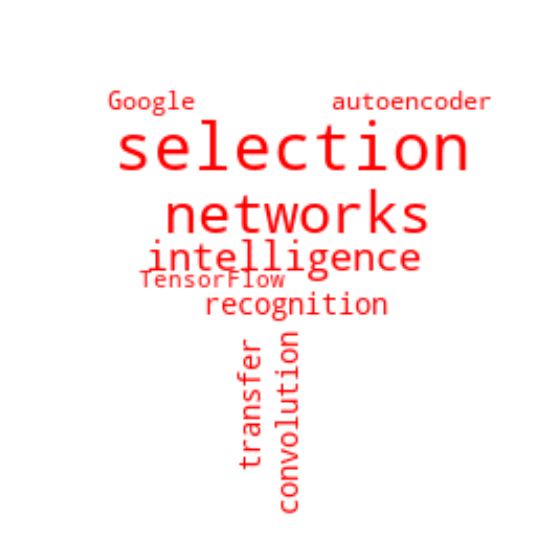

In [34]:
#Create "Down Arrow" mask for the word cloud
decr_char_mask = np.array(Image.open("images/darrow.jpeg"))  

# Generate a word cloud image of the biggest downward trends:
wordcloud_decr = WordCloud(width = 2000, height = 2000, 
                background_color ='white', mask=decr_char_mask, 
                min_font_size = 10, 
                color_func=lambda *args, **kwargs: (255,0,0)
                ).generate_from_frequencies(decr_dict)

# Display the generated image:
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud_decr, interpolation='bilinear')
plt.axis("off")
plt.show()

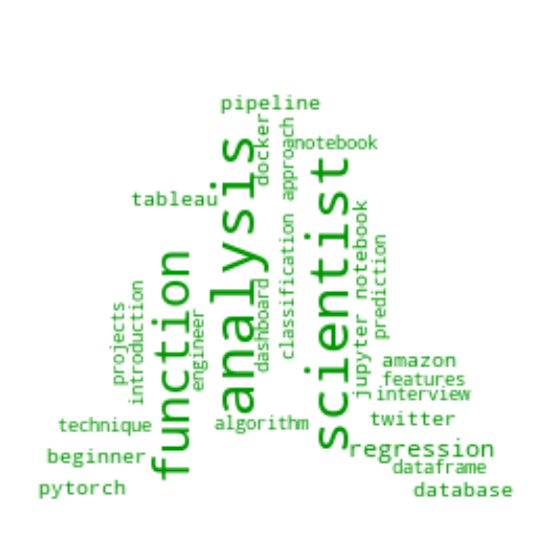

In [27]:
#Create "Up Arrow" mask for the word cloud
incr_char_mask = np.array(Image.open("images/arrow.jpeg"))     

# Generate a word cloud image of the biggest upward trends:
wordcloud_incr = WordCloud(width = 2000, height = 2000, 
                background_color ='white', mask=incr_char_mask,
                min_font_size = 8, color_func=lambda *args, **kwargs: (0,150,0)
                ).generate_from_frequencies(incr_dict)

# Display the generated image:
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud_incr, interpolation='bilinear')
plt.axis("off")
plt.show()

# Extract Text from Top/Bottom 35% of Articles 

In [32]:
#Determine the popular articles in each year
for i in [df_2018, df_2019, df_2020]:
    nlp.popular(i)    

#Merge the years into one Data Frame
df_pop_reg = pd.concat([df_2018, df_2019, df_2020])

#Change date column to datetime
df_pop_reg.date = pd.to_datetime(df_pop_reg['date'])

#Add Year column
df_pop_reg['year'] = pd.DatetimeIndex(df_pop_reg['date']).year

#Only retain the most and least popular articles
df_pop_cla = df_pop_reg[df_pop_reg['popular']!=2]

#Export Data Frame for use in supervised regression models
#df_pop_reg.to_csv('data/df_supervised_regression_models.csv')

#Export Data Frame for use in supervised classification models
#df_pop_cla.to_csv('data/df_supervised_classification_models.csv')

In [36]:
#See how many articles fall into the range of popular
df_pop_cla['popular'].value_counts()

1    12119
0    12114
Name: popular, dtype: int64

In [9]:
#Scrape the full text of articles from TowardsDataScience.com that are in the top/bottom 35% of total 'claps' 
scraper.get_medium_text(df_pop_cla)

#Save to csv
#df_pop_cla.to_csv('data/pop_text_medium.csv')